In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [3]:
def read_file(root_file_path):
    with uproot.open(root_file_path) as root_file:
        decision_tree = root_file["decision_tree_data_tree"]

        count = decision_tree["rSensorCount"].array()
        fprompt90 = decision_tree["rFprompt90"].array()
        fprompt200 = decision_tree["rFprompt200"].array()
        is_signal = decision_tree["isSignal"].array()

        return count, fprompt90, fprompt200, is_signal  


In [4]:
count, fprompt90, fprompt200, is_signal = read_file("/home/lane/Software/src/lumilar/system/analysis/data/decision_tree_data.root")

In [5]:
X = np.column_stack((count, fprompt90, fprompt200))
Y = is_signal

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

clf = xgb.XGBClassifier()
clf.fit(X_train, Y_train)
accuracy = clf.score(X_test, Y_test)

print(f"Accuracy: {accuracy*100:.2f}%")


Accuracy: 83.50%


Particle: 0
Probability: [0.9995684  0.9973659  0.44098258 ... 0.9998496  0.6664766  0.905464  ]
Particle: 1
Probability: [4.3158911e-04 2.6341195e-03 5.5901742e-01 ... 1.5036267e-04 3.3352342e-01
 9.4535992e-02]


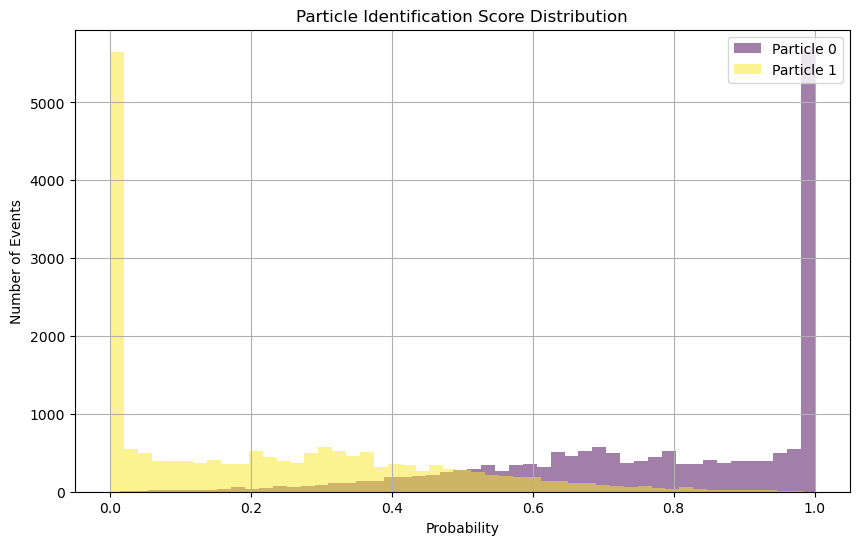

ValueError: the truth value of an array whose length is not 1 is ambiguous; use ak.any() or ak.all()

<Figure size 640x480 with 0 Axes>

In [9]:
probabilities = clf.predict_proba(X_test)

plt.figure(figsize=(10, 6))
particle_types = clf.classes_  
colors = plt.cm.viridis(np.linspace(0, 1, len(particle_types)))

for idx, ptype in enumerate(particle_types):
    print(f"Particle: {ptype}")
    print(f"Probability: {probabilities[:, idx]}")
    plt.hist(probabilities[:, idx], bins=50, alpha=0.5, label=f"Particle {ptype}", color=colors[idx])

plt.legend(loc='upper right')
plt.xlabel('Probability')
plt.ylabel('Number of Events')
plt.title('Particle Identification Score Distribution')
plt.grid(True)
plt.show()


features = ['count', 'fprompt90', 'fprompt200']
for feature in features:
    plt.figure()
    sns.histplot(data=X, x=feature, hue=Y, element='step', stat='density')
    plt.title(f'Distribution of {feature}')
    plt.show()

# Training and Evaluation
clf = xgb.XGBClassifier()
clf.fit(X_train, Y_train)

# Accuracy & AUC-ROC
accuracy = clf.score(X_test, Y_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(Y_test, y_pred_prob)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC-ROC: {roc_auc:.2f}")

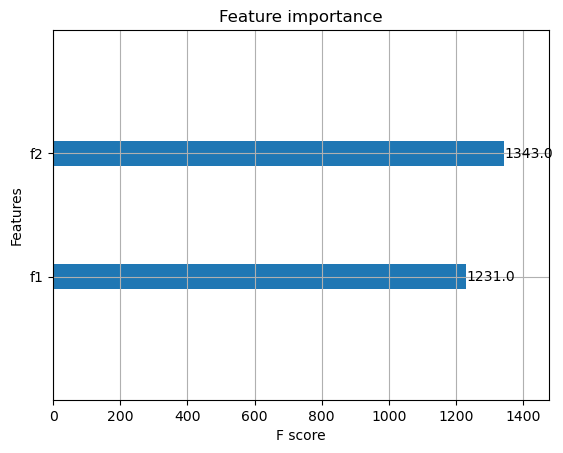

In [ ]:
xgb.plot_importance(clf)
plt.show()

In [ ]:
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'max_depth': [10],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'min_child_weight': [5]
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X, Y)

best_clf = grid_search.best_estimator_

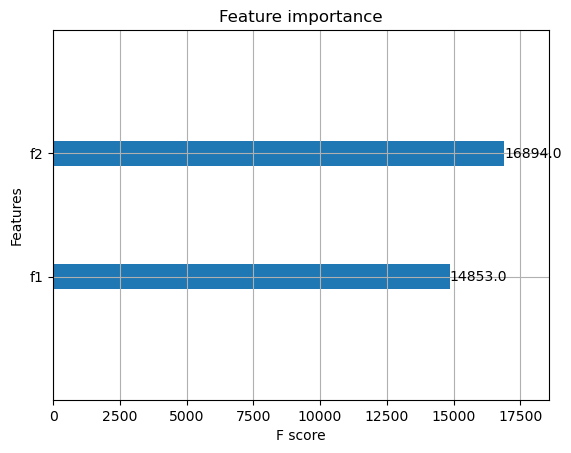

In [ ]:
xgb.plot_importance(best_clf)
plt.show()

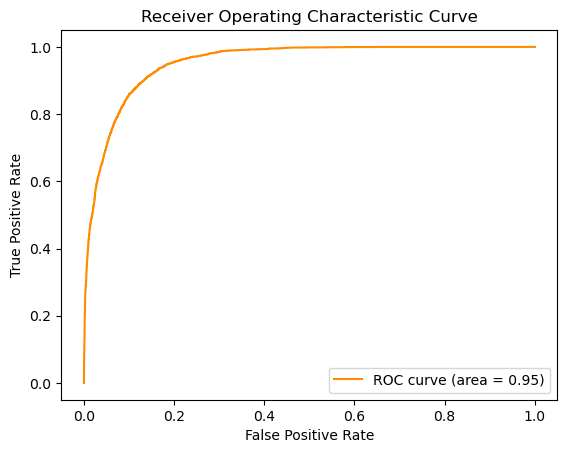

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming you've split your data into train and test sets.
y_pred_prob = best_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import shap

explainer = shap.Explainer(best_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


ValueError: the truth value of an array whose length is not 1 is ambiguous; use ak.any() or ak.all()

ValueError: the truth value of an array whose length is not 1 is ambiguous; use ak.any() or ak.all()

<Figure size 800x270 with 1 Axes>

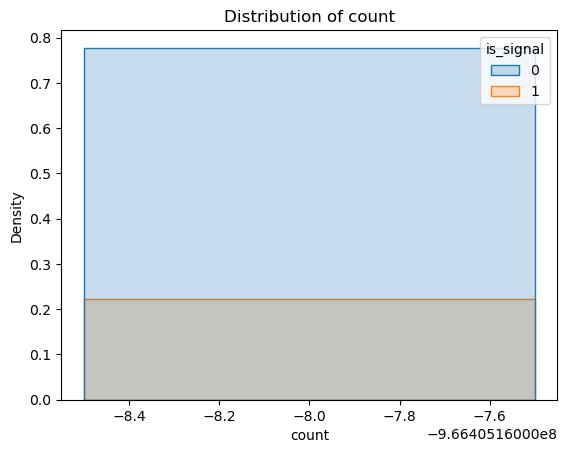

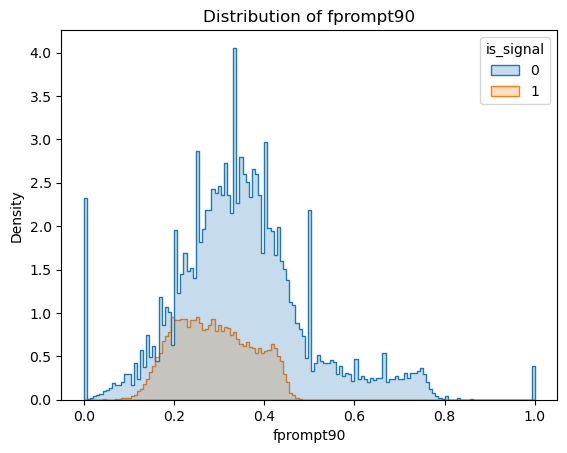

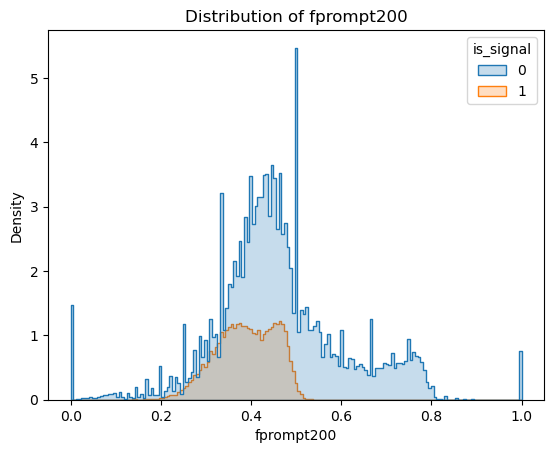

Accuracy: 83.50%
AUC-ROC: 0.89


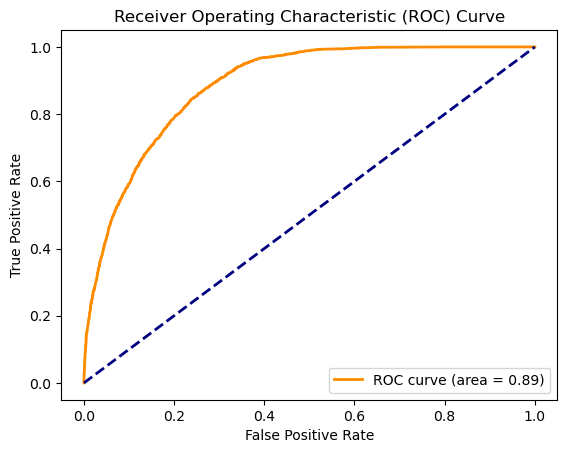

<Figure size 640x480 with 0 Axes>

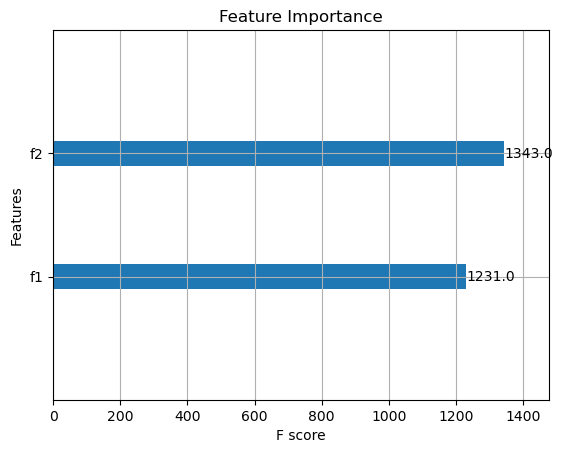

5-fold CV Accuracy: 81.73% ± 3.73%


In [11]:
import pandas as pd

# ... [other imports and function definitions]

# Convert X and Y to a DataFrame
df = pd.DataFrame(X, columns=['count', 'fprompt90', 'fprompt200'])
df['is_signal'] = Y

# Data Exploration
features = ['count', 'fprompt90', 'fprompt200']
for feature in features:
    plt.figure()
    sns.histplot(data=df, x=feature, hue='is_signal', element='step', stat='density')
    plt.title(f'Distribution of {feature}')
    plt.show()

# Training and Evaluation
clf = xgb.XGBClassifier()
clf.fit(X_train, Y_train)

# Accuracy & AUC-ROC
accuracy = clf.score(X_test, Y_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(Y_test, y_pred_prob)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC-ROC: {roc_auc:.2f}")

# Plotting AUC-ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
plt.figure()
xgb.plot_importance(clf, importance_type='weight')
plt.title('Feature Importance')
plt.show()

# Cross-validation
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(clf, X, Y, cv=cv, scoring='accuracy')
print(f"5-fold CV Accuracy: {np.mean(cv_scores)*100:.2f}% ± {np.std(cv_scores)*100:.2f}%")